In [8]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
import matplotlib

In [30]:
# defining inputs
EXPLOSIVE_MASS = 19.4
DISTANCE_EXPLOSIVE_TO_SURFACE = 6.1
CORNER_COORDINATES_OF_SURFACE = ([-9, -2.5], [2, -2.5], [-9, 7], [2, 7])  # ll, lr, ul, ur
EXPLOSIVE_POSITION = [0, 0]
MESH_SIZE = 0.01
ANN_MODEL_FILE = 'Peak_Reflected_Pressure_ANN_1_nodrop_noscale.h5'

In [31]:
def generate_surface_coordinates(corner_coordinates, mesh_size):
    ll, lr, ul, ur = corner_coordinates

    # Generate grid of coordinates with mesh size
    x_range = np.arange(ll[0], lr[0] + mesh_size, mesh_size)
    y_range = np.arange(ll[1], ul[1] + mesh_size, mesh_size)[::-1]  # Reverse y_range to match the matrix orientation
    x_coords, y_coords = np.meshgrid(x_range, y_range)

    # Create a 2D matrix with coordinates in corresponding positions
    surface_matrix = np.empty_like(x_coords, dtype=object)
    for i in range(surface_matrix.shape[0]):
        for j in range(surface_matrix.shape[1]):
            surface_matrix[i, j] = (x_coords[i, j], y_coords[i, j])

    return surface_matrix

def calculate_angles(surface_matrix, distance_explosive_to_surface):
    origin_x, origin_y = 0, 0

    angle_surface_matrix = np.empty(surface_matrix.shape, dtype=object)
    for i in range(surface_matrix.shape[0]):
        for j in range(surface_matrix.shape[1]):
            distance_from_origin_to_point = np.sqrt((surface_matrix[i, j][0] - origin_x) ** 2 + (surface_matrix[i, j][1] - origin_y) ** 2)
            angle_radians = np.arctan(distance_from_origin_to_point/distance_explosive_to_surface)  # find the angle
            angle_degrees = np.round(np.degrees(angle_radians),0)  # Convert radians to degrees, define the required precision
            angle_surface_matrix[i, j] = angle_degrees  # Store angle in degrees
    return angle_surface_matrix

def calculate_distances(surface_matrix, distance_explosive_to_surface):
    origin_x, origin_y = 0, 0

    distance_surface_matrix = np.empty(surface_matrix.shape, dtype=object)
    for i in range(surface_matrix.shape[0]):
        for j in range(surface_matrix.shape[1]):
            distance_from_origin_to_point = np.sqrt((surface_matrix[i, j][0] - origin_x) ** 2 + (surface_matrix[i, j][1] - origin_y) ** 2)
            distance_surface_matrix[i, j] = np.sqrt(distance_explosive_to_surface ** 2 + distance_from_origin_to_point ** 2)  # find the distance
    return distance_surface_matrix

def generate_a_random_2d_matrix(width, height):
    random_matrix = np.random.rand(height, width)
    return random_matrix

def generate_heatmap(random_heatmap_df, surface_coordinates_df):
    
    cdict = {'red': ((0.0, 0.0, 0.0),
                 (0.25, 0.2, 0.2),
                 (0.5, 0.0, 0.0),
                 (0.75, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green':((0.0, 0.0, 0.0),
                 (0.25, 1.0, 1.0),
                 (0.5, 1.0, 1.0),
                 (0.75, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
        'blue': ((0.0, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5, 0.0, 0.0),
                 (0.75, 0.0, 0.0),
                 (1.0, 0.0, 0.0))}
    my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

    
    # Reshape the random heatmap DataFrame to match the surface_coordinates_df
    heatmap_values = random_heatmap_df.values.reshape(surface_coordinates_df.shape[0], surface_coordinates_df.shape[1])

    # Create heatmap with x and y coordinates as axis ticks
    plt.imshow(heatmap_values, cmap=my_cmap, extent=[surface_coordinates_df[0, 0][0],
                                                       surface_coordinates_df[-1, -1][0],
                                                       surface_coordinates_df[-1, -1][1],
                                                       surface_coordinates_df[0, 0][1]])
    plt.colorbar(label='Peak Reflected Pressure')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Heatmap of Pressure Values on the Surface')
    plt.savefig('Contour.png', dpi = 600, bbox_inches = 'tight')
    plt.show()

def generate_x_dataset(surface_coordinates, distance_explosive_to_surface, explosive_mass, isTNT):

    # calculate the angles or distances to the pints in the surface from the explosive location
    surface_coordinates_angles = calculate_angles(surface_coordinates, distance_explosive_to_surface)
    # surface_coordinates_distances = calculate_distances(surface_coordinates, distance_explosive_to_surface)

    # flatten the surface coordinates/distances into a 1D array
    surface_coordinates_angles_flat = surface_coordinates_angles.flatten()

    unique_angles = np.unique(surface_coordinates_angles_flat)

    # Create a 2D matrix with the specified columns
    num_points = len(surface_coordinates_angles_flat)
    x_dataset = np.zeros((num_points, 5))
    x_dataset[:, 0] = explosive_mass  # Set the first column to explosive_mass
    x_dataset[:, 1] = distance_explosive_to_surface  # Set the second column to distance_explosive_to_surface
    x_dataset[:, 2] = surface_coordinates_angles_flat  # Set the third column to surface_coordinates_angles_flat
    # x_dataset[:, 2] = surface_coordinates_angles_flat_int  # Set the third column to surface_coordinates_angles_flat
    x_dataset[:, 3] = np.where(isTNT, 0, 1)  # Set the fourth column: 1 if not isTNT, 0 otherwise
    x_dataset[:, 4] = np.where(isTNT, 1, 0)  # Set the fifth column: 1 if isTNT, 0 otherwise

    return x_dataset

def predict_pressures(ann_model_file, x_dataset):
    model = load_model(ann_model_file)
    predictions = model.predict(x_dataset)

    return predictions

32721/32721 [==============================] - 55s 2ms/step


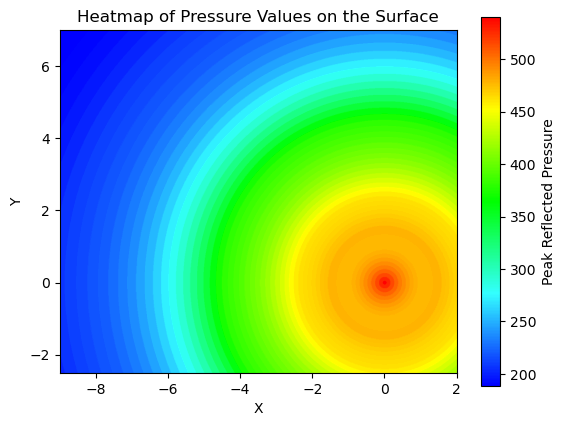

In [32]:
# Generate surface coordinates
surface_coordinates = generate_surface_coordinates(CORNER_COORDINATES_OF_SURFACE, MESH_SIZE)

# generate the x dataset
x_dataset = generate_x_dataset(surface_coordinates, DISTANCE_EXPLOSIVE_TO_SURFACE, EXPLOSIVE_MASS, False)

# load the ANN model and predict for the x_dataset
predictions = predict_pressures(ANN_MODEL_FILE, x_dataset)

predictions_df = pd.DataFrame(predictions.flatten(), columns=['value'])

# Generate heatmap
generate_heatmap(predictions_df, surface_coordinates)